# About Dataset
### WHAT IS MARKET SEGMENTATION?
In marketing, market segmentation is the process of dividing a broad consumer or business market, normally consisting of existing and potential customers, into subgroups of consumers based on some type of shared characteristics.

###### Objective :
This case requires developing a customer segmentation to give recommendations like saving plans, loans, wealth management, etc. on target customer groups.

###### Dataset
The sample Dataset summarizes the usage behavior of about 9000 active credit cardholders during the last 6 months. The file is at a customer level with 18 behavioral variables.
Variables of Dataset:
Balance,
Balance Frequency,
Purchases,
One-off Purchases,
Installment Purchases,
Cash Advance,
Purchases Frequency,
One-off Purchases Frequency,
Purchases Installments Frequency,
Cash Advance Frequency,
Cash Advance TRX,
Purchases TRX,
Credit Limit,
Payments,
Minimum Payments,
PRC Full payment,
Tenure,
Cluster

The sample Dataset summarizes the usage behavior of about 9000 active credit cardholders during the last 6 months. The file is at a customer level with 18 behavioral variables.

In [1]:
def warn (*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.impute import KNNImputer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans,DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from matplotlib.patches import Ellipse
%matplotlib inline

### Exploratory Data Analysis (EDA) and Understanding Data

In [2]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
  
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)


def plt_graph(model, X, label=True, ax=None):
    if model == GaussianMixture():
        ax = ax or plt.gca()
        labels = model.fit(X).predict(X)
        if label:
            ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='jet', zorder=2)
        else:
            ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
        ax.axis('equal')

        w_factor = 0.2 / model.weights_.max()
        for pos, covar, w in zip(model.means_, model.covariances_, model.weights_):
            draw_ellipse(pos, covar, alpha=w * w_factor)
    else:
        ax = ax or plt.gca()
        labels = model.fit(X).predict(X)
        if label:
            ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='jet', zorder=2)
        else:
            ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
        ax.axis('equal')

def plt_3d_tsne(mod,X_split):
    tsne = TSNE(n_components=3, init = "random", learning_rate = "auto", random_state=99)
    X_reduceds = tsne.fit_transform(X_split)
    tsne_pred = mod.fit(X_reduceds).predict(X_reduceds)

    # plotting

    X_reduceds = pd.DataFrame(X_reduceds, columns=(['TSNE 1', 'TSNE 2', 'TSNE 3']))
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X_reduceds['TSNE 1'],X_reduceds['TSNE 2'],X_reduceds['TSNE 3'], c=tsne_pred)
    ax.set_title("3D projection of the clusters")

    
def plt_3d_pca(mod,X_split):
    pca = PCA(n_components=3, random_state=99)
    X_reduceds = pca.fit_transform(X_split)
    pca_pred = mod.fit(X_reduceds).predict(X_reduceds)

    # plotting

    X_reduceds = pd.DataFrame(X_reduceds, columns=(['PCA 1', 'PCA 2', 'PCA 3']))
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X_reduceds['PCA 1'],X_reduceds['PCA 2'],X_reduceds['PCA 3'], c=pca_pred)
    ax.set_title("3D projection of the clusters")
    
    
def plt_jet(model, X, figsizes=(10,8)):
    labels = model.fit(X).predict(X)
    plt.figure(figsize=figsizes)
    plt.scatter(X[:, 0], X[:, 1], c = labels.astype(np.int8), cmap="jet", alpha=0.5)
    plt.colorbar()
    plt.show()

In [3]:
df = pd.read_csv("Customerdata.csv")
df.sample(5)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
6434  C16610   710.811464               0.75     633.87            320.00   
5951  C16117  1253.188317               1.00     320.34              0.00   
104   C10109   862.072380               1.00       0.00              0.00   
5895  C16061  1196.364009               1.00       0.00              0.00   
7676  C17882  2455.423773               1.00    2695.07            227.97   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
6434                  313.87    672.991175             0.750000   
5951                  320.34      0.000000             0.666667   
104                     0.00    920.309805             0.000000   
5895                    0.00   1376.669494             0.000000   
7676                 2467.10   1440.078629             0.833333   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
6434                    0.125000                          0.625000   
5951                    0.000000                          0.666667   
104                     0.000000                          0.000000   
5895                    0.000000                          0.000000   
7676                    0.166667                          0.750000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
6434                0.250000                 4             17        1000.0   
5951                0.000000                 0             11        1500.0   
104                 0.083333                 1              0        4000.0   
5895                0.250000                 7              0        1500.0   
7676                0.333333                 6             22        3000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
6434   474.226839        686.170196          0.000000       8  
5951  1229.226379        324.954747          0.000000      12  
104   2236.890255        214.828158          0.083333      12  
5895   293.144474        307.355494          0.000000      12  
7676  2963.914089        882.951164          0.000000      12

In [4]:
df.shape

(8950, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [6]:
df.describe().T

count         mean          std        min  \
BALANCE                           8950.0  1564.474828  2081.531879   0.000000   
BALANCE_FREQUENCY                 8950.0     0.877271     0.236904   0.000000   
PURCHASES                         8950.0  1003.204834  2136.634782   0.000000   
ONEOFF_PURCHASES                  8950.0   592.437371  1659.887917   0.000000   
INSTALLMENTS_PURCHASES            8950.0   411.067645   904.338115   0.000000   
CASH_ADVANCE                      8950.0   978.871112  2097.163877   0.000000   
PURCHASES_FREQUENCY               8950.0     0.490351     0.401371   0.000000   
ONEOFF_PURCHASES_FREQUENCY        8950.0     0.202458     0.298336   0.000000   
PURCHASES_INSTALLMENTS_FREQUENCY  8950.0     0.364437     0.397448   0.000000   
CASH_ADVANCE_FREQUENCY            8950.0     0.135144     0.200121   0.000000   
CASH_ADVANCE_TRX                  8950.0     3.248827     6.824647   0.000000   
PURCHASES_TRX                     8950.0    14.709832    24.857649   0.000000   
CREDIT_LIMIT                      8949.0  4494.449450  3638.815725  50.000000   
PAYMENTS                          8950.0  1733.143852  2895.063757   0.000000   
MINIMUM_PAYMENTS                  8637.0   864.206542  2372.446607   0.019163   
PRC_FULL_PAYMENT                  8950.0     0.153715     0.292499   0.000000   
TENURE                            8950.0    11.517318     1.338331   6.000000   

                                          25%          50%          75%  \
BALANCE                            128.281915   873.385231  2054.140036   
BALANCE_FREQUENCY                    0.888889     1.000000     1.000000   
PURCHASES                           39.635000   361.280000  1110.130000   
ONEOFF_PURCHASES                     0.000000    38.000000   577.405000   
INSTALLMENTS_PURCHASES               0.000000    89.000000   468.637500   
CASH_ADVANCE                         0.000000     0.000000  1113.821139   
PURCHASES_FREQUENCY                  0.083333     0.500000     0.916667   
ONEOFF_PURCHASES_FREQUENCY           0.000000     0.083333     0.300000   
PURCHASES_INSTALLMENTS_FREQUENCY     0.000000     0.166667     0.750000   
CASH_ADVANCE_FREQUENCY               0.000000     0.000000     0.222222   
CASH_ADVANCE_TRX                     0.000000     0.000000     4.000000   
PURCHASES_TRX                        1.000000     7.000000    17.000000   
CREDIT_LIMIT                      1600.000000  3000.000000  6500.000000   
PAYMENTS                           383.276166   856.901546  1901.134317   
MINIMUM_PAYMENTS                   169.123707   312.343947   825.485459   
PRC_FULL_PAYMENT                     0.000000     0.000000     0.142857   
TENURE                              12.000000    12.000000    12.000000   

                                          max  
BALANCE                           19043.13856  
BALANCE_FREQUENCY                     1.00000  
PURCHASES                         49039.57000  
ONEOFF_PURCHASES                  40761.25000  
INSTALLMENTS_PURCHASES            22500.00000  
CASH_ADVANCE                      47137.21176  
PURCHASES_FREQUENCY                   1.00000  
ONEOFF_PURCHASES_FREQUENCY            1.00000  
PURCHASES_INSTALLMENTS_FREQUENCY      1.00000  
CASH_ADVANCE_FREQUENCY                1.50000  
CASH_ADVANCE_TRX                    123.00000  
PURCHASES_TRX                       358.00000  
CREDIT_LIMIT                      30000.00000  
PAYMENTS                          50721.48336  
MINIMUM_PAYMENTS                  76406.20752  
PRC_FULL_PAYMENT                      1.00000  
TENURE                               12.00000

In [7]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [8]:
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64

In [9]:
#In this code snippet, I used the KNNImputer to fill missing values using the K-Nearest Neighbors (KNN) method.
clean = KNNImputer(n_neighbors=7,weights="distance")
numerical = df[null_columns].select_dtypes(exclude = "object").columns
df[numerical] = clean.fit_transform(df[numerical])

In [10]:
df.drop(columns=['CUST_ID'], inplace=True)

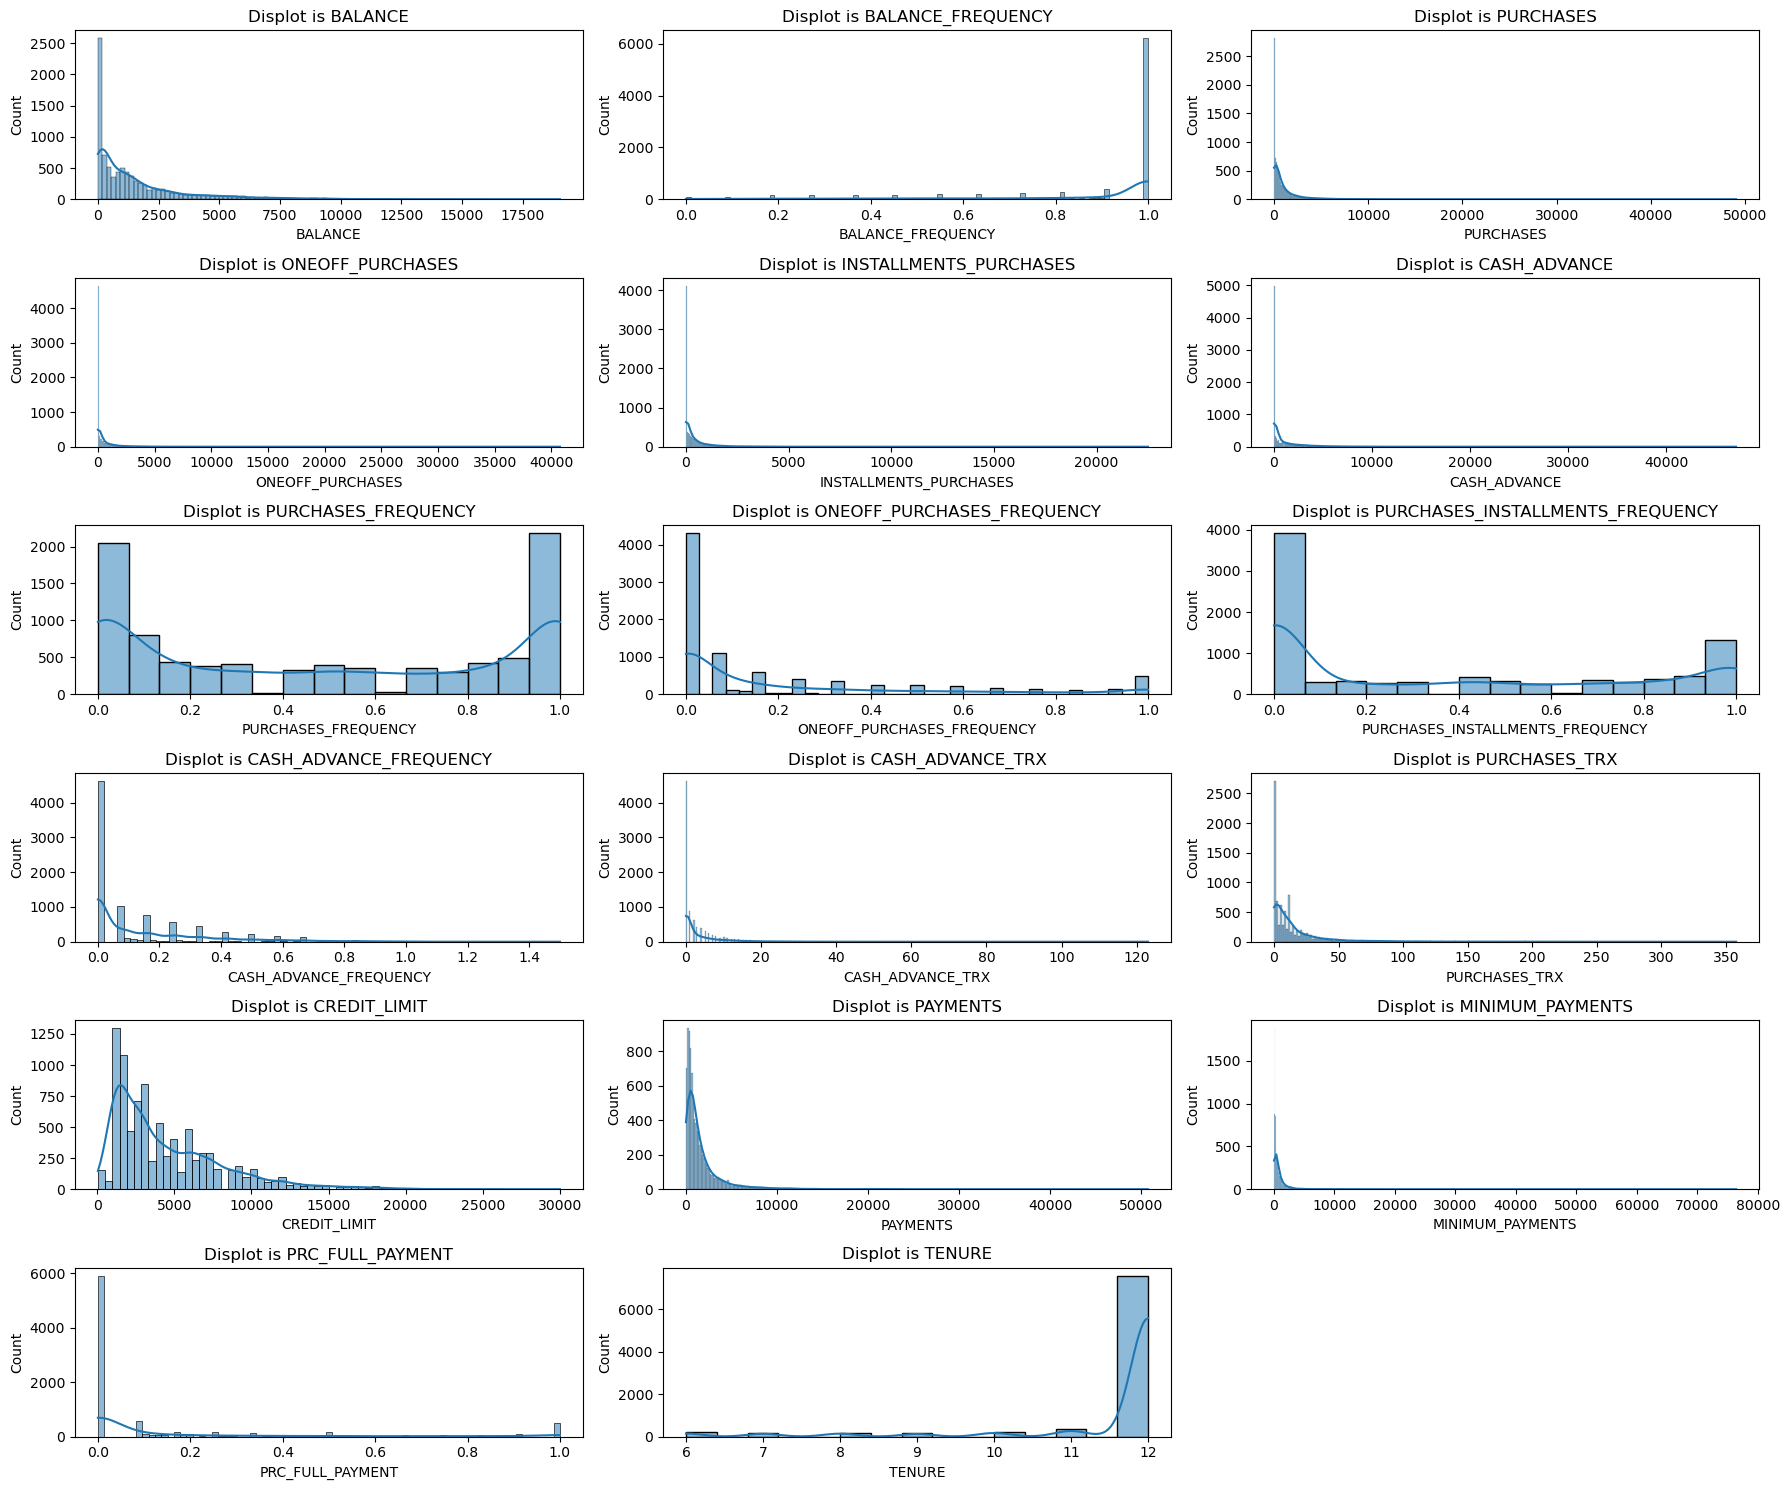

In [11]:
ds_columns = df.columns
plt.figure(figsize=(18,15))

for i in range(len(ds_columns)):
    plt.subplot(6 , 3, i+1)
    sns.histplot(x=df[ds_columns[i]], kde=True)
    plt.title("Displot is {}".format(ds_columns[i]))
    plt.tight_layout()

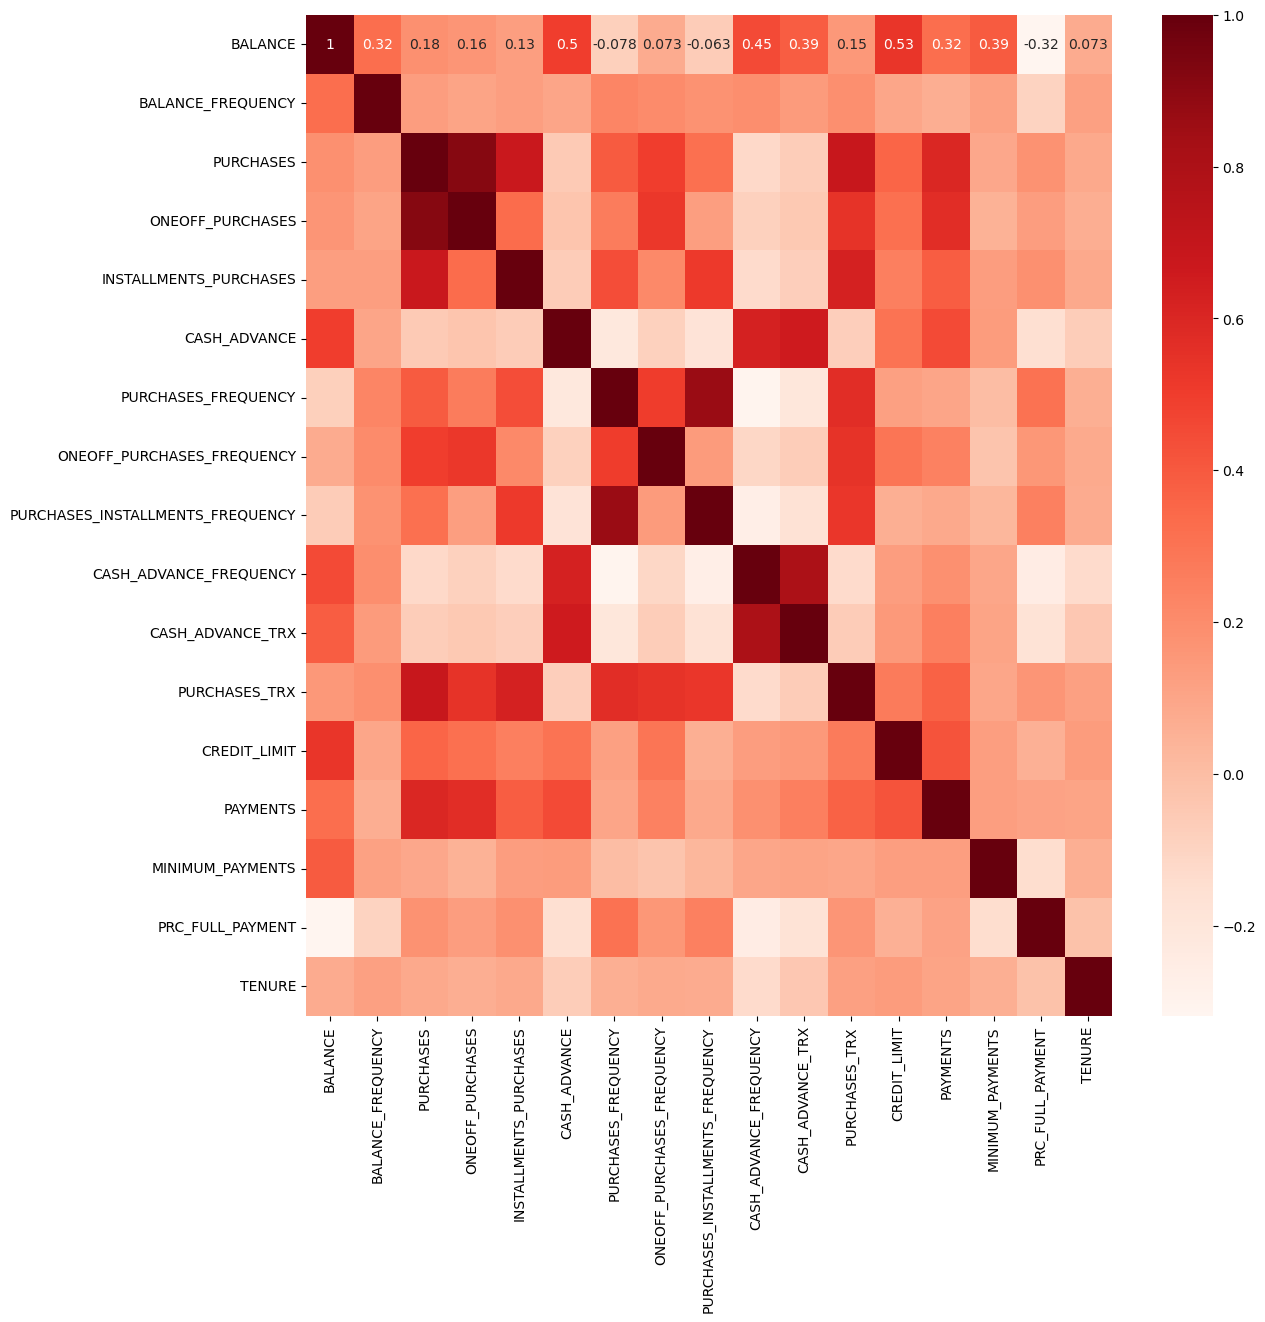

In [12]:
plt.figure(figsize=(13,13))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap = plt.cm.Reds)
plt.show()

## Modeling and Model Improvement

In [13]:
scaler = StandardScaler()
df = scaler.fit_transform(df)

In [14]:
X_train, X_test= train_test_split(df, test_size=0.8, shuffle = True ,random_state=99)

### KMEANS Clustering

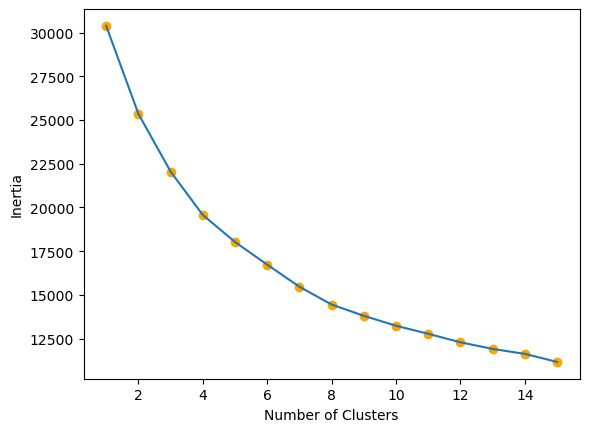

In [15]:
inertia = []
list_num_clusters = list(range(1,16))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters,init = "k-means++",algorithm="auto", random_state=99)
    km.fit(X_train)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia, c = "orange", marker = "o")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

##### Sometimes, the elbow method does not yield a clear decision (for example, if the elbow is not clear and sharp, or is ambiguous). In such cases, alternatives such as the silhouette coefficient can be helpful.

In [16]:
silhouette_train_scores = []
silhouette_test_scores = []
max_clusters = 15

for i in range(2, max_clusters + 1):
    km = KMeans(n_clusters=i, init="k-means++",algorithm="auto", random_state=99)
    labels = km.fit_predict(X_train)
    score = silhouette_score(X_train, labels)
    silhouette_train_scores.append(score)
    
    labels_test = km.fit_predict(X_test)
    score_test= silhouette_score(X_test, labels_test)
    silhouette_test_scores.append(score_test)

In [17]:
cluster_numbers = list(range(2, max_clusters + 1))

df_silhouette = pd.DataFrame({'Train_Silhouette': silhouette_train_scores, 'Test_Silhouette': silhouette_test_scores}, index=cluster_numbers)
df_silhouette.index.name = 'cluster_num'
df_silhouette

Train_Silhouette  Test_Silhouette
cluster_num                                   
2                    0.295085         0.209360
3                    0.248316         0.251521
4                    0.190070         0.199367
5                    0.185052         0.195004
6                    0.189794         0.205279
7                    0.202331         0.212153
8                    0.211096         0.224362
9                    0.205099         0.228966
10                   0.209571         0.223783
11                   0.199570         0.222799
12                   0.205845         0.225099
13                   0.214928         0.221848
14                   0.193077         0.222371
15                   0.202175         0.205865

### Dimensionality Reduction

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init = "random", learning_rate = "auto", random_state=99)
%time X_reduced = tsne.fit_transform(X_train)

CPU times: total: 21.5 s
Wall time: 11.3 s


In [19]:
pca = PCA(n_components=2)
%time X_pca_reduced = pca.fit_transform(X_train)

CPU times: total: 469 ms
Wall time: 1.21 s


In [20]:
X_reduced

array([[  7.179174 , -39.612854 ],
       [ -1.8702326,  13.171103 ],
       [ 43.516502 ,   6.4544463],
       ...,
       [ -7.673927 , -12.234711 ],
       [-19.19888  , -40.542675 ],
       [-14.705709 ,  24.398235 ]], dtype=float32)

In [21]:
X_pca_reduced

array([[ 5.01095569,  0.3030639 ],
       [-1.38183696, -0.86071042],
       [-1.68210997,  3.18797717],
       ...,
       [ 0.23452136, -1.02950242],
       [ 1.91937012, -0.33397502],
       [-2.151621  , -0.64853092]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


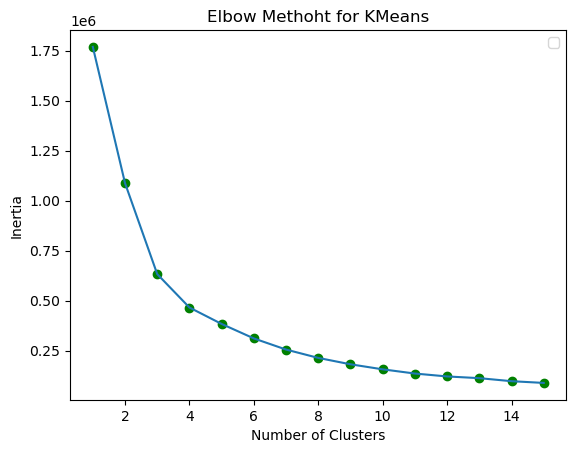

In [22]:
inertia = []
list_num_clusters = list(range(1,16))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters,init = "k-means++",algorithm="auto", random_state=99)
    km.fit(X_reduced)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia, c="green", marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title("Elbow Methoht for KMeans")
plt.legend()
plt.show()

##### This time, we observe that the elbow method is effective. Elbow value is = 3

In [23]:
kmeans_elb = KMeans(n_clusters= 4 , init = "k-means++", algorithm = "auto", random_state=99)

In [24]:
kmeans_elb.fit(X_reduced)

KMeans(algorithm='auto', n_clusters=4, random_state=99)

In [25]:
silhouette_score_elb_train = silhouette_score(X_train, kmeans_elb.fit_predict(X_train))
silhouette_score_elb_test = silhouette_score(X_test , kmeans_elb.fit_predict(X_test))

print("Silhouette Score for Train: {}".format(silhouette_score_elb_train))
print("Silhouette Score for Test: {}".format(silhouette_score_elb_test))

Silhouette Score for Train: 0.19006957659271329
Silhouette Score for Test: 0.1993668917533159


In [26]:
X_reduced_f = X_reduced.astype(np.float32)
X_reduced_f

array([[  7.179174 , -39.612854 ],
       [ -1.8702326,  13.171103 ],
       [ 43.516502 ,   6.4544463],
       ...,
       [ -7.673927 , -12.234711 ],
       [-19.19888  , -40.542675 ],
       [-14.705709 ,  24.398235 ]], dtype=float32)

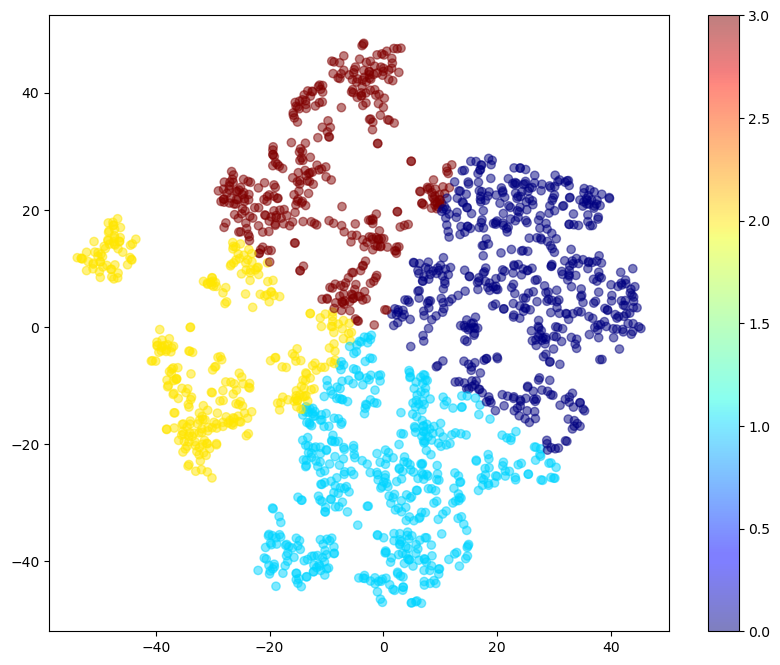

In [27]:
plt_jet(kmeans_elb,X_reduced)

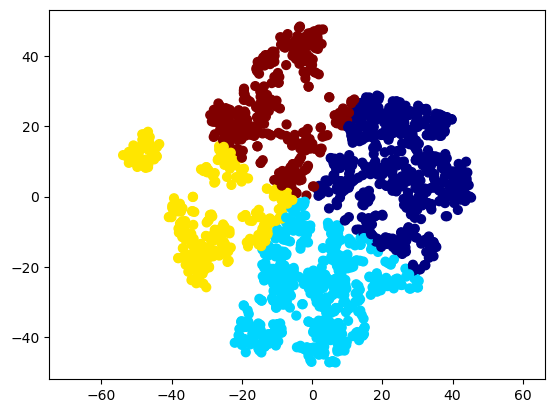

In [28]:
plt_graph(kmeans_elb,X_reduced)

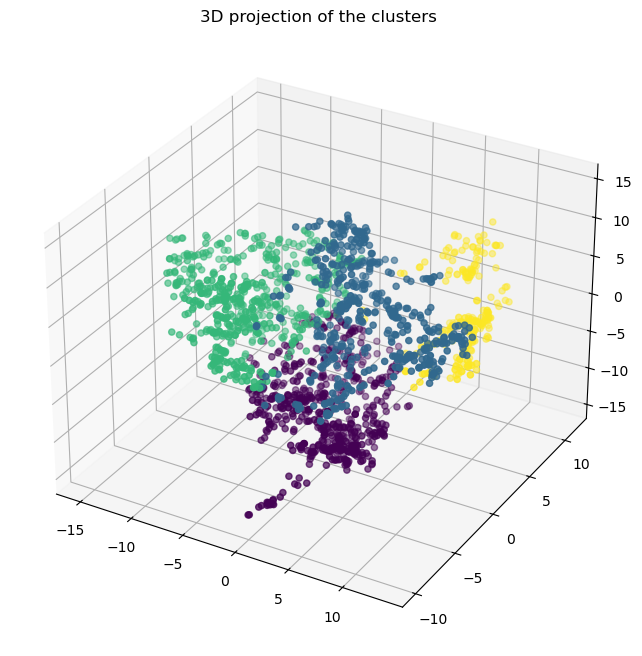

In [29]:
plt_3d_tsne(kmeans_elb, X_train)

In [30]:
kmeans_pca = KMeans(n_clusters= 4 , init = "k-means++", algorithm = "auto", random_state=99)

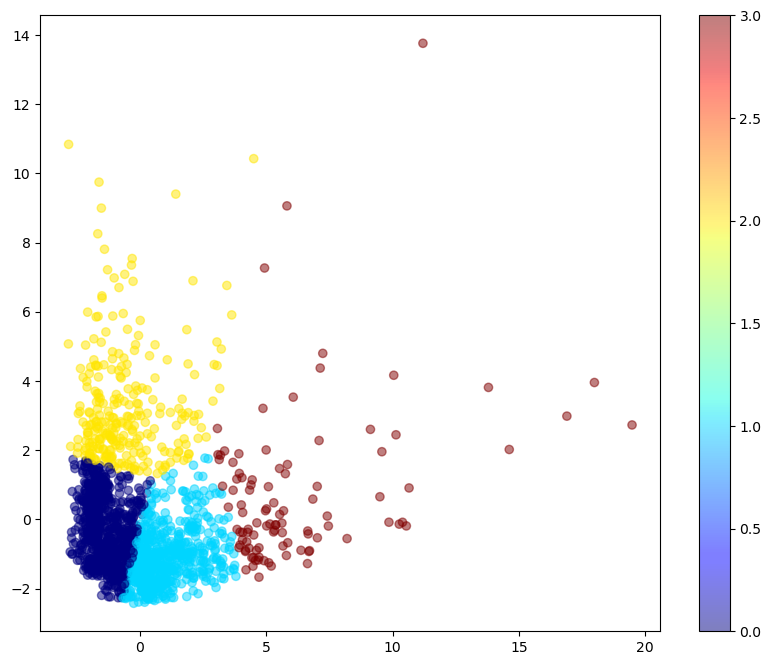

In [31]:
plt_jet(kmeans_pca, X_pca_reduced)

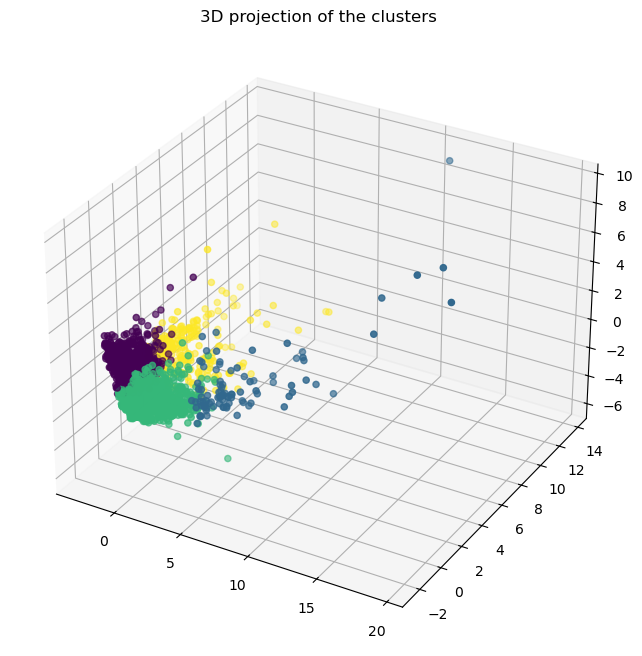

In [32]:
plt_3d_pca(kmeans_pca, X_train)

### MİNİBATCH Clustering

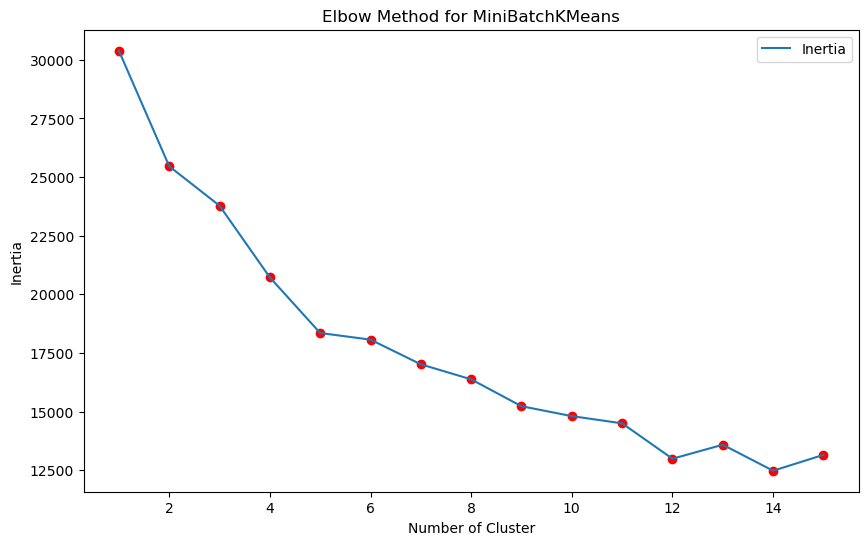

In [33]:
inertia_batch = []
n_cluster_batch = list(range(1, 16))

plt.figure(figsize=(10, 6)) 

for cluster_num_batch in n_cluster_batch:
    minibatch = MiniBatchKMeans(n_clusters=cluster_num_batch, batch_size=100, init="k-means++")
    minibatch.fit(X_train)
    inertia_batch.append(minibatch.inertia_)

plt.plot(n_cluster_batch, inertia_batch, label='Inertia')
plt.scatter(n_cluster_batch, inertia_batch, c='red', marker='o')
plt.xlabel("Number of Cluster")
plt.ylabel("Inertia")
plt.title("Elbow Method for MiniBatchKMeans")
plt.legend()
plt.show()


##### Elbow method didn't work.

In [34]:
silhouette_score_batch_train = []
silhouette_score_batch_test = []
n_cluster_batch= range(2,16)
for num_cluster in n_cluster_batch:
    minibatch = MiniBatchKMeans(n_clusters = num_cluster, batch_size= 100, init="k-means++")
    labels = minibatch.fit_predict(X_train)
    silhouette_score_batch = silhouette_score(X_train,labels)
    silhouette_score_batch_train.append(silhouette_score_batch)
    
    labels_test = minibatch.fit_predict(X_test)
    silhouette_score_test = silhouette_score(X_test,labels_test)
    silhouette_score_batch_test.append(silhouette_score_test)
    
cluster_num = list(range(2,16))
df_silhouette_batch = pd.DataFrame({"Train_Silhouette":silhouette_score_batch_train, "Test_Silhouette":silhouette_score_batch_test},index=cluster_num)
df_silhouette_batch.index.name = "Cluster Num"
df_silhouette_batch

Train_Silhouette  Test_Silhouette
Cluster Num                                   
2                    0.207052         0.204700
3                    0.209413         0.158432
4                    0.188771         0.147722
5                    0.164952         0.199957
6                    0.130155         0.205453
7                    0.140464         0.200733
8                    0.190014         0.113442
9                    0.194788         0.151114
10                   0.178562         0.173705
11                   0.185114         0.163410
12                   0.202091         0.154754
13                   0.148315         0.134683
14                   0.137719         0.158095
15                   0.114745         0.195380

In [35]:
minibatch = MiniBatchKMeans(n_clusters=7, batch_size = 100, init="k-means++")

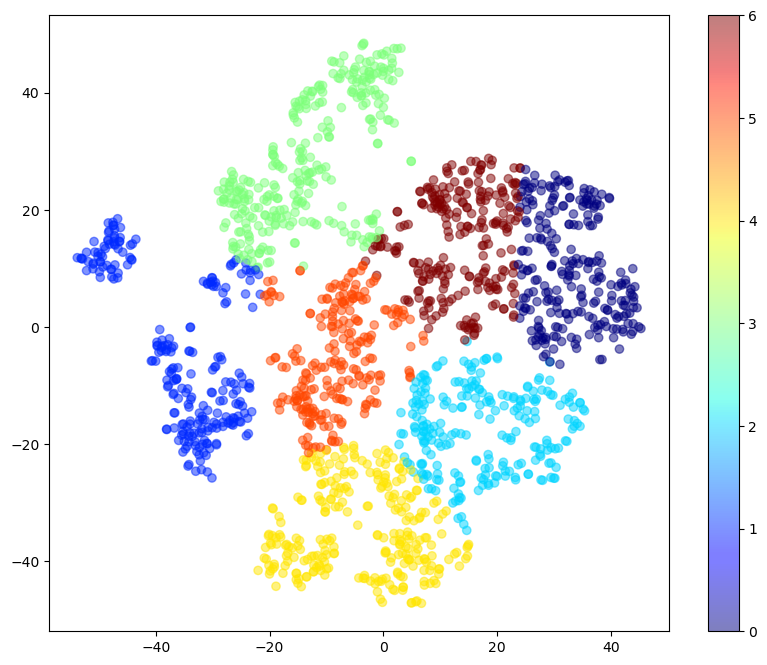

In [36]:
plt_jet(minibatch, X_reduced)

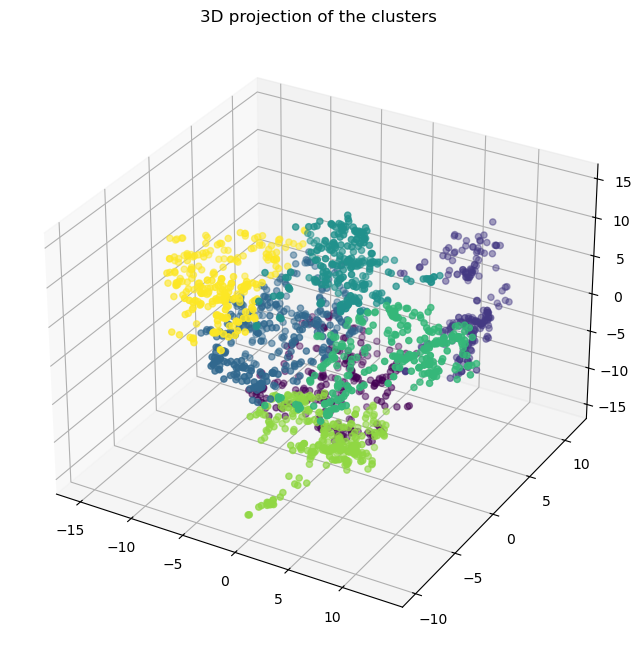

In [37]:
plt_3d_tsne(minibatch, X_train)

In [38]:
kmeans_mini_pca = MiniBatchKMeans(n_clusters = 7, batch_size=100, random_state=99)

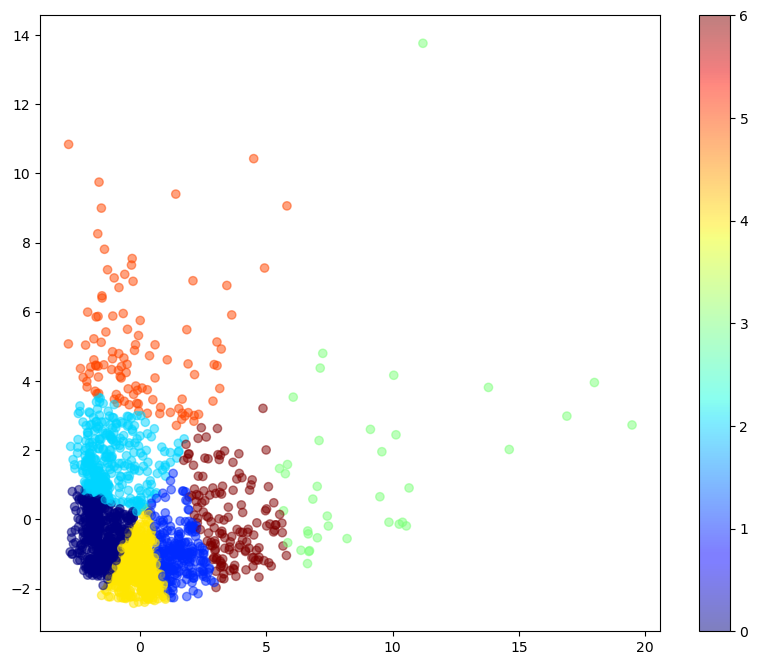

In [39]:
plt_jet(kmeans_mini_pca, X_pca_reduced)

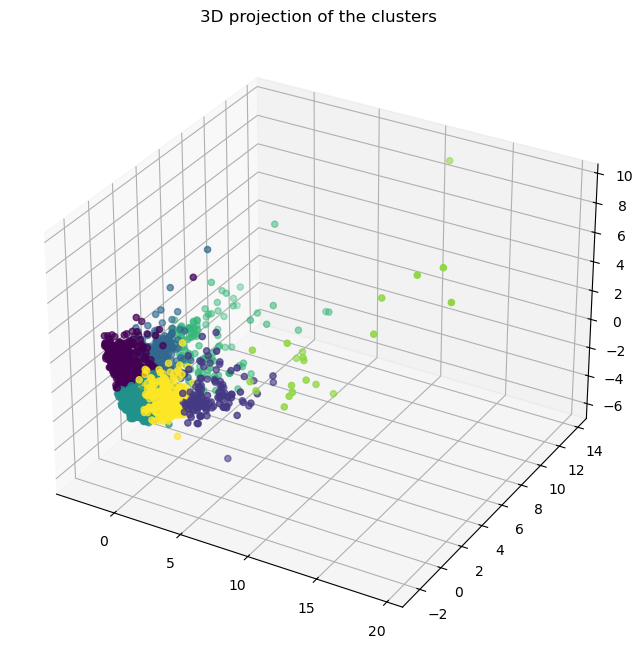

In [40]:
plt_3d_pca(kmeans_mini_pca, X_train)

### DBSCAN Clustering

In [41]:
dbscn = DBSCAN(eps =6 , min_samples = 38)
dbscn.fit(X_reduced)
print(f'DBCSANd found {len(set(dbscn.labels_)-set([-1]))} clusters and {(dbscn.labels_ ==-1).sum()} point of noise.')


DBCSANd found 7 clusters and 69 point of noise.


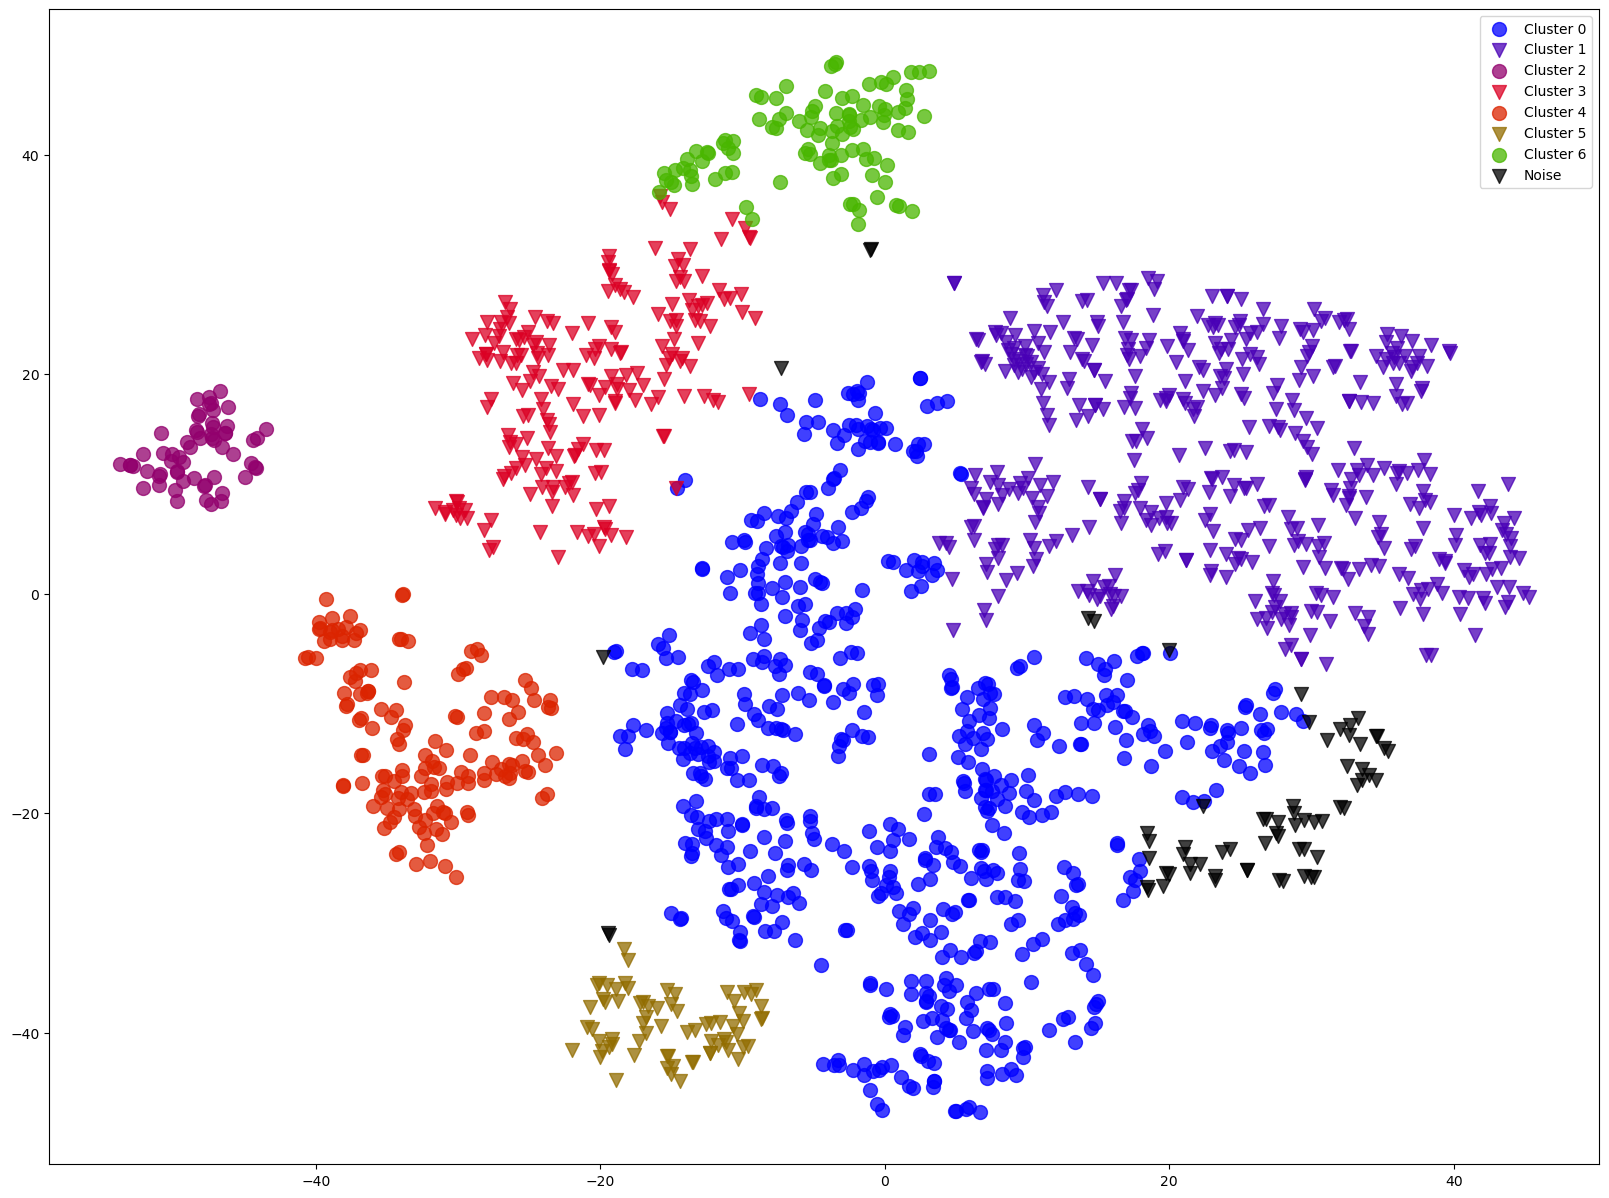

In [42]:
plt.rcParams['figure.figsize'] = (20,15)
unique_labels = set(dbscn.labels_)
n_labels = len(unique_labels)
cmap = plt.cm.get_cmap('brg', n_labels)
for l in unique_labels:
    plt.scatter(
        X_reduced[dbscn.labels_ == l, 0],
        X_reduced[dbscn.labels_ == l, 1],
        c=[cmap(l) if l >= 0 else 'Black'],
        marker='ov'[l%2],
        alpha=0.75,
        s=100,
        label=f'Cluster {l}' if l >= 0 else 'Noise')
plt.legend(bbox_to_anchor=[1, 1])
plt.show()
plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

#### The percentage of noise

In [43]:
print(f"{100*(dbscn.labels_ == -1).sum()/len(dbscn.labels_)}%")

3.8547486033519553%


### GAUSSİAN MİXTURE Clustering 

In [44]:
gmm = GaussianMixture(n_components = 10, covariance_type = "full", random_state=99)

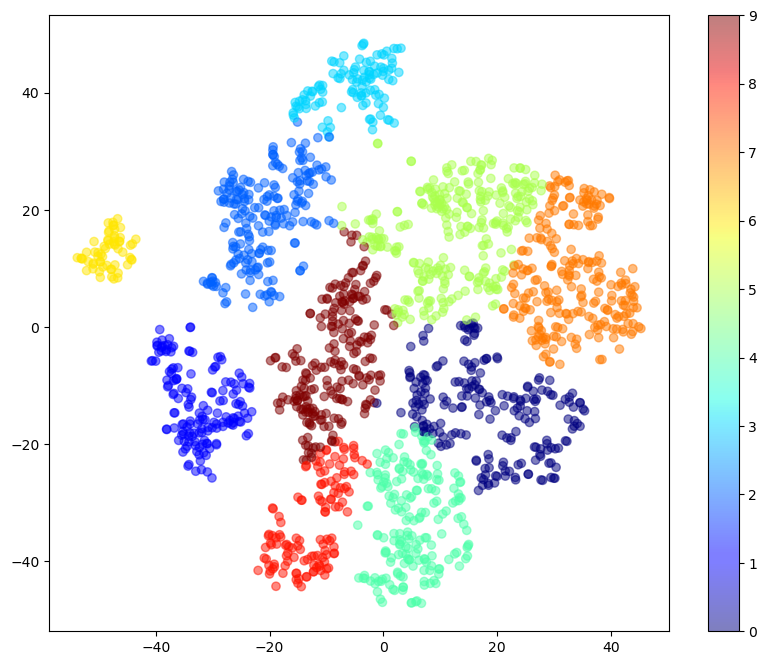

In [45]:
plt_jet(gmm, X_reduced)

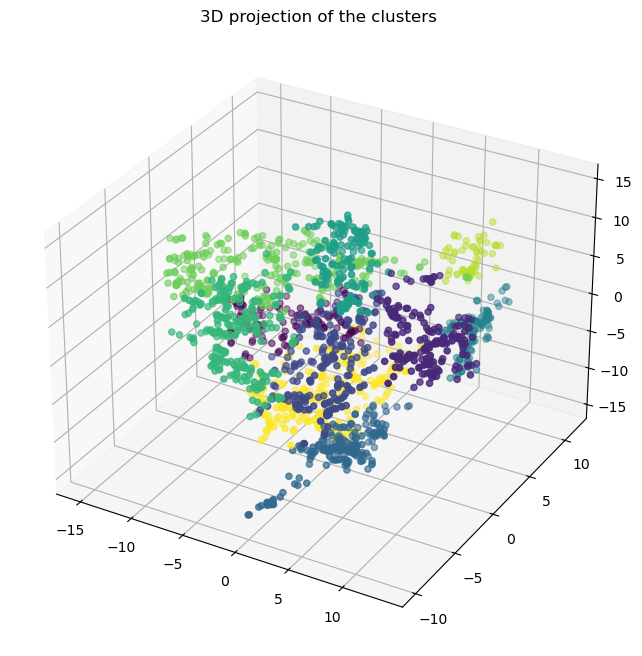

In [46]:
plt_3d_tsne(gmm,X_train)

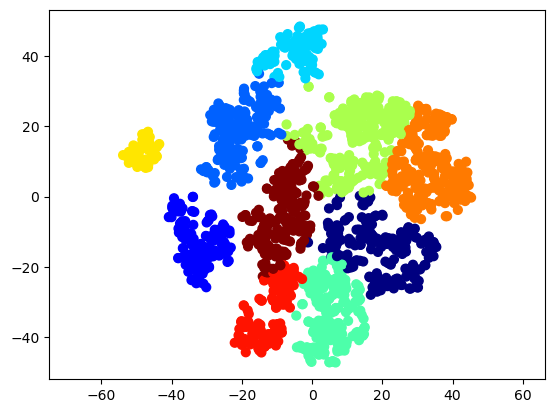

In [47]:
plt_graph(gmm, X_reduced)

In [48]:
gmm_pca = GaussianMixture(n_components = 10, covariance_type ="full", random_state=99)

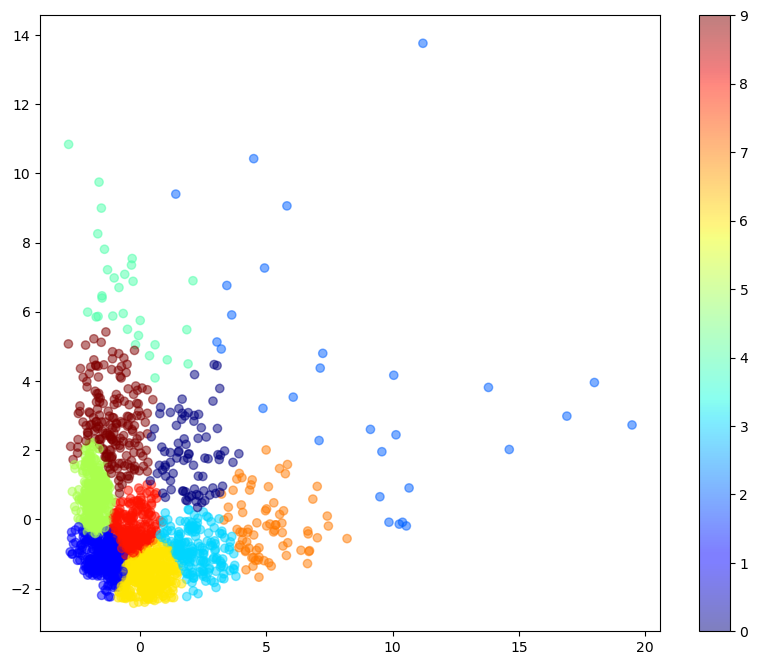

In [49]:
plt_jet(gmm_pca, X_pca_reduced)

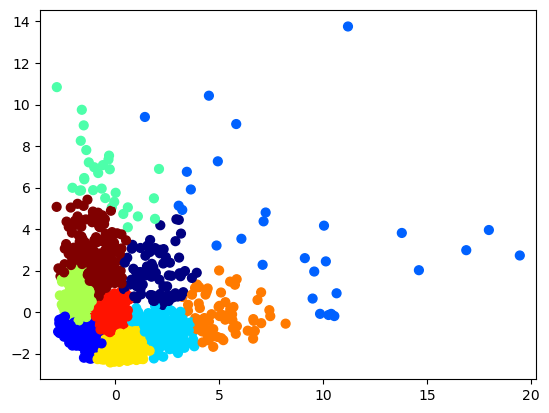

In [50]:
plt_graph(gmm_pca, X_pca_reduced)

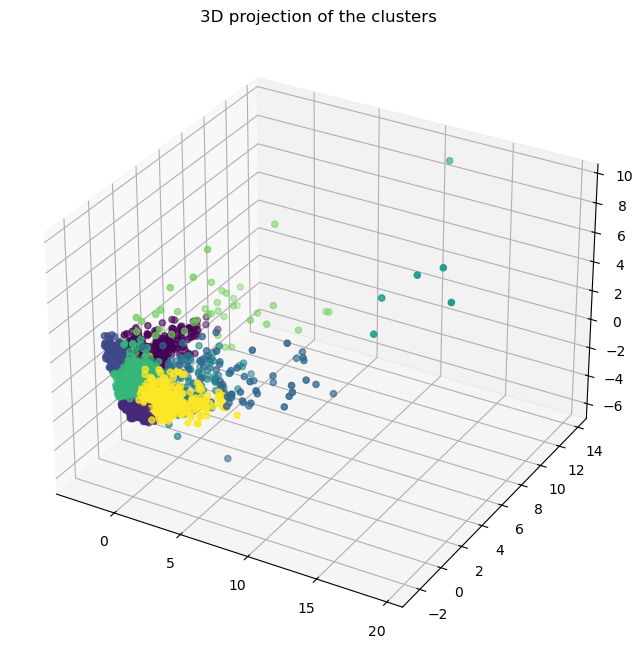

In [51]:
plt_3d_pca(gmm, X_train)

### MEAN-SHIFT Clustering

In [52]:
#bandwidth = estimate_bandwidth(X_train)`estimate_bandwidth` function is a method for automatically estimating the bandwidth for the Mean Shift algorithm.
#I manually adjusted the bandwidth because it didn't perform well on my dataset.
ms = MeanShift(bandwidth=12 , bin_seeding=True)
ms.fit(X_train)

MeanShift(bandwidth=12, bin_seeding=True)

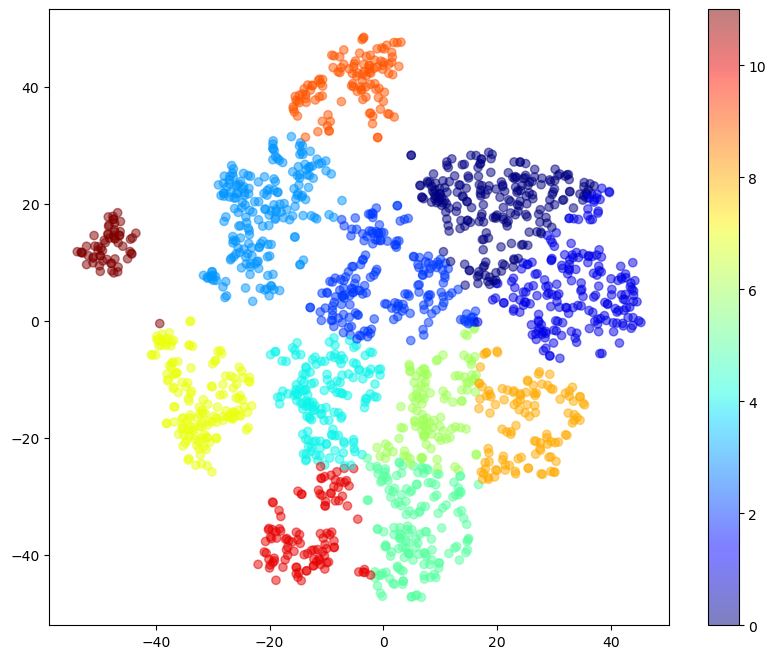

In [53]:
plt_jet(ms, X_reduced)

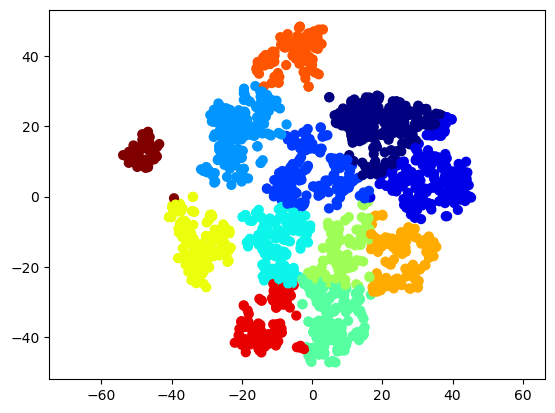

In [54]:
plt_graph(ms, X_reduced)

###  Agglomerative Clustering (Hierarchical)

In [55]:
train_pred = []
test_pred = []
n_cluster_agg= range(2,16)
for num_clust in n_cluster_agg:
    aggclustering = AgglomerativeClustering(n_clusters=num_clust, affinity = "euclidean", linkage="ward")
    agg_pred_train = aggclustering.fit_predict(X_train)
    agg_pred_test = aggclustering.fit_predict(X_test)
    
    silhouette_scores_train= silhouette_score(X_train,agg_pred_train) 
    silhouette_sccores_test = silhouette_score(X_test , agg_pred_test)
    train_pred.append(silhouette_scores_train)
    test_pred.append(silhouette_sccores_test)
cluster_num = list(range(2,16))
agg_df = pd.DataFrame({"Train Score":train_pred, "Test Score":test_pred}, index =cluster_num)
agg_df.index.name = "Cluster Num"
agg_df

Train Score  Test Score
Cluster Num                         
2               0.444244    0.174958
3               0.291765    0.165408
4               0.151334    0.167543
5               0.165895    0.125781
6               0.170769    0.139990
7               0.159327    0.131263
8               0.167836    0.138467
9               0.157568    0.145860
10              0.159405    0.152154
11              0.161983    0.159389
12              0.162599    0.137584
13              0.167356    0.141127
14              0.162325    0.150842
15              0.165412    0.156139

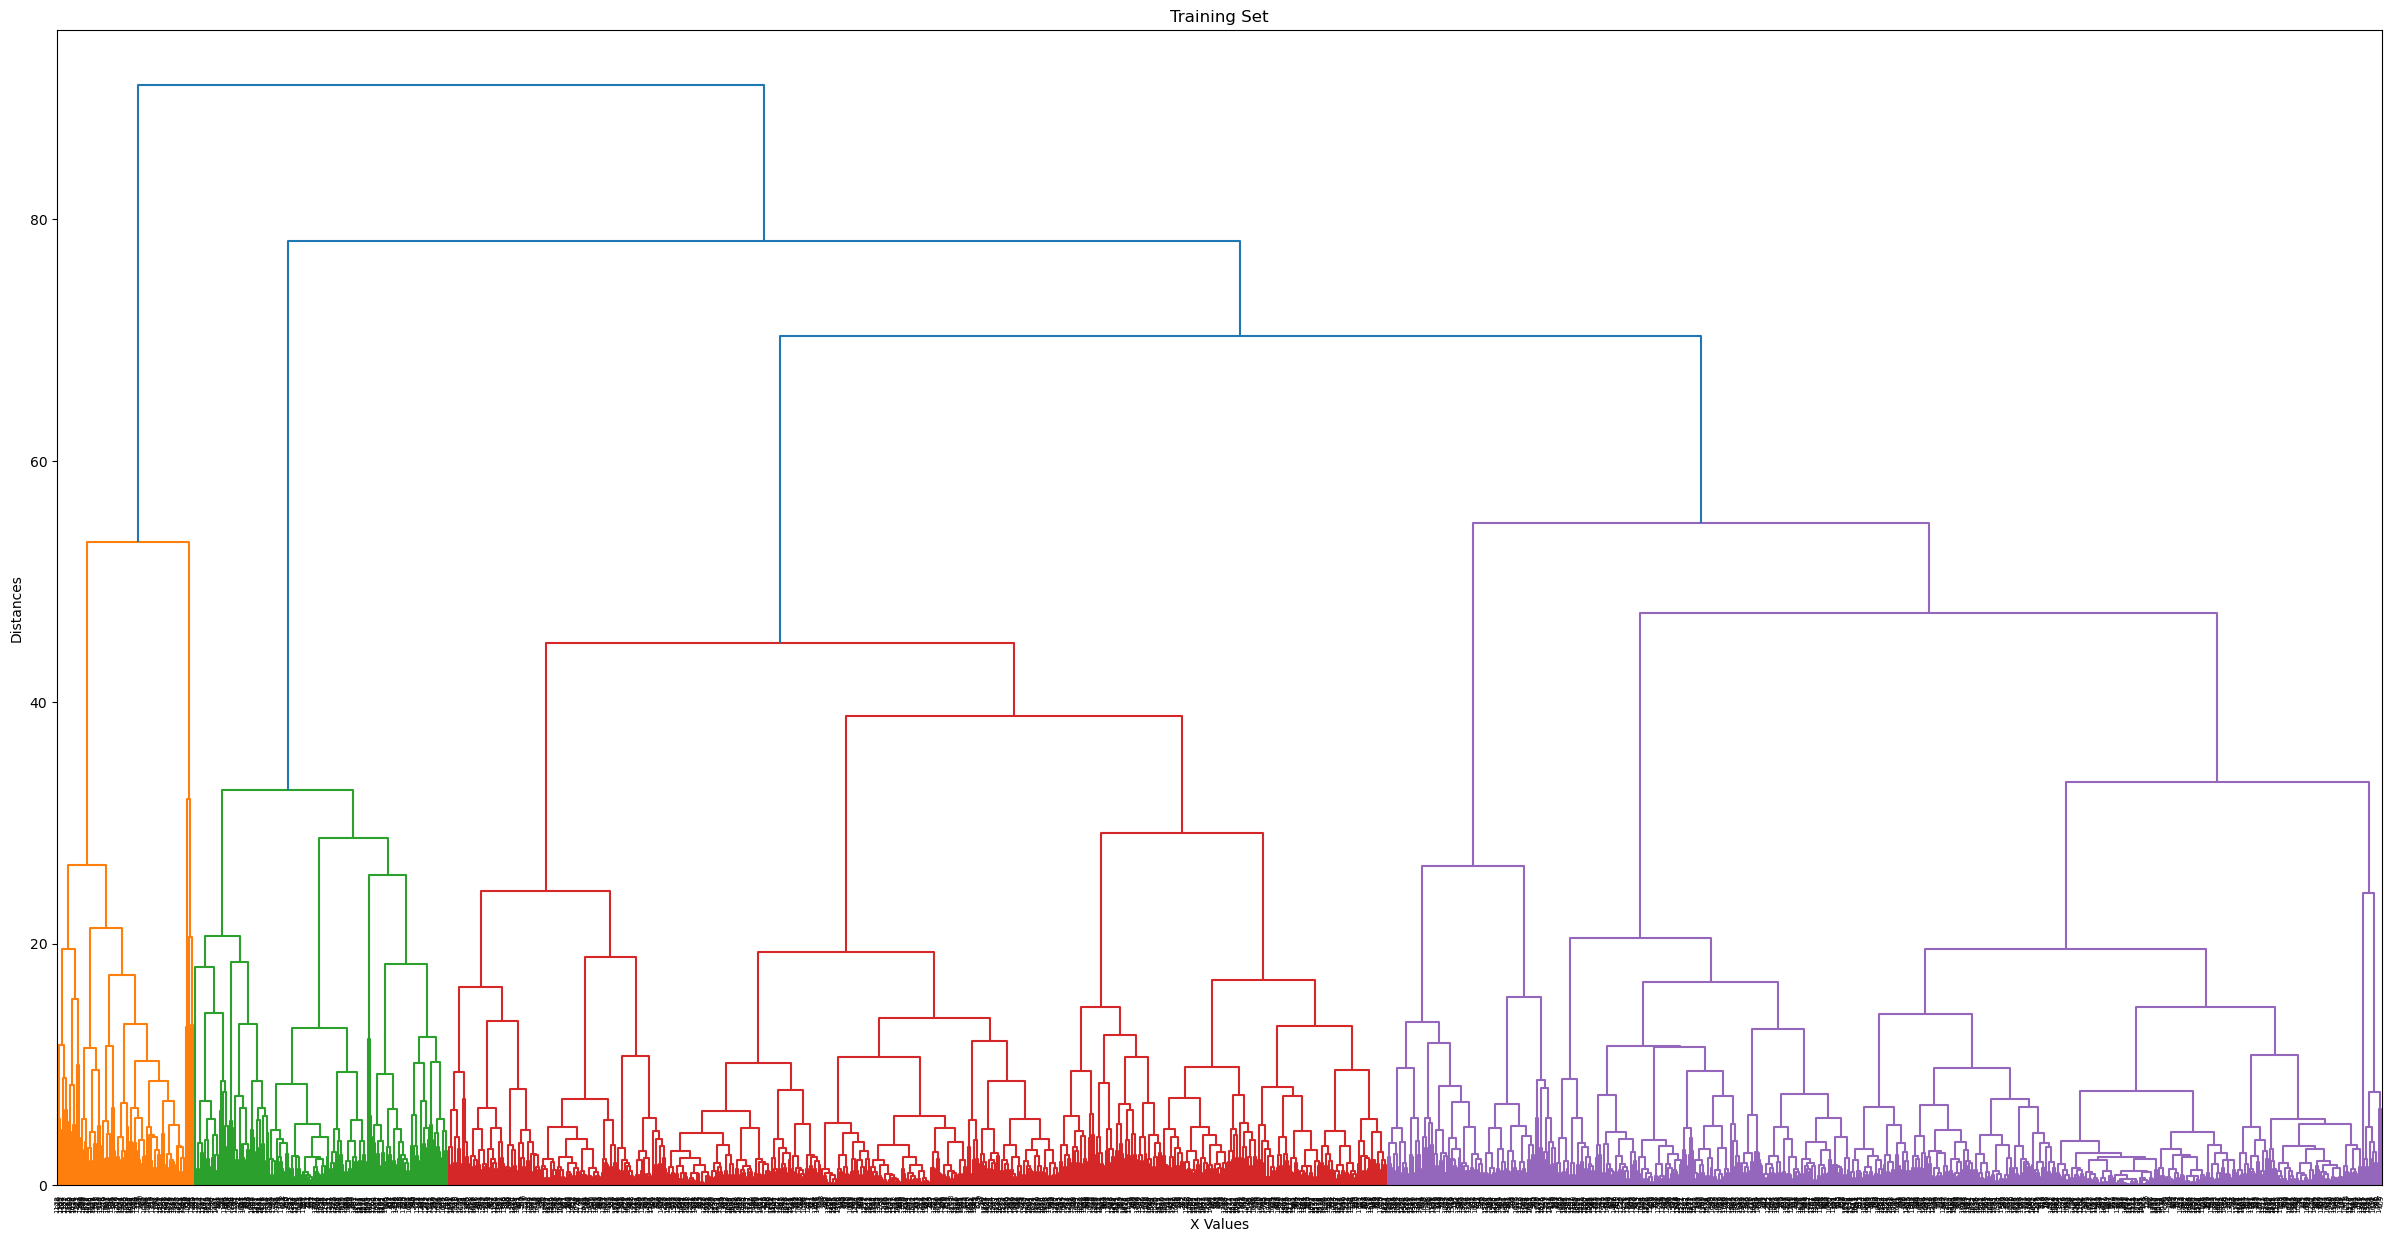

In [56]:
plt.figure(figsize=(30,15))
dendrogram = sch.dendrogram(sch.linkage(X_train, method = 'ward'))
plt.title('Training Set')
plt.xlabel('X Values')
plt.ylabel('Distances')
plt.show()

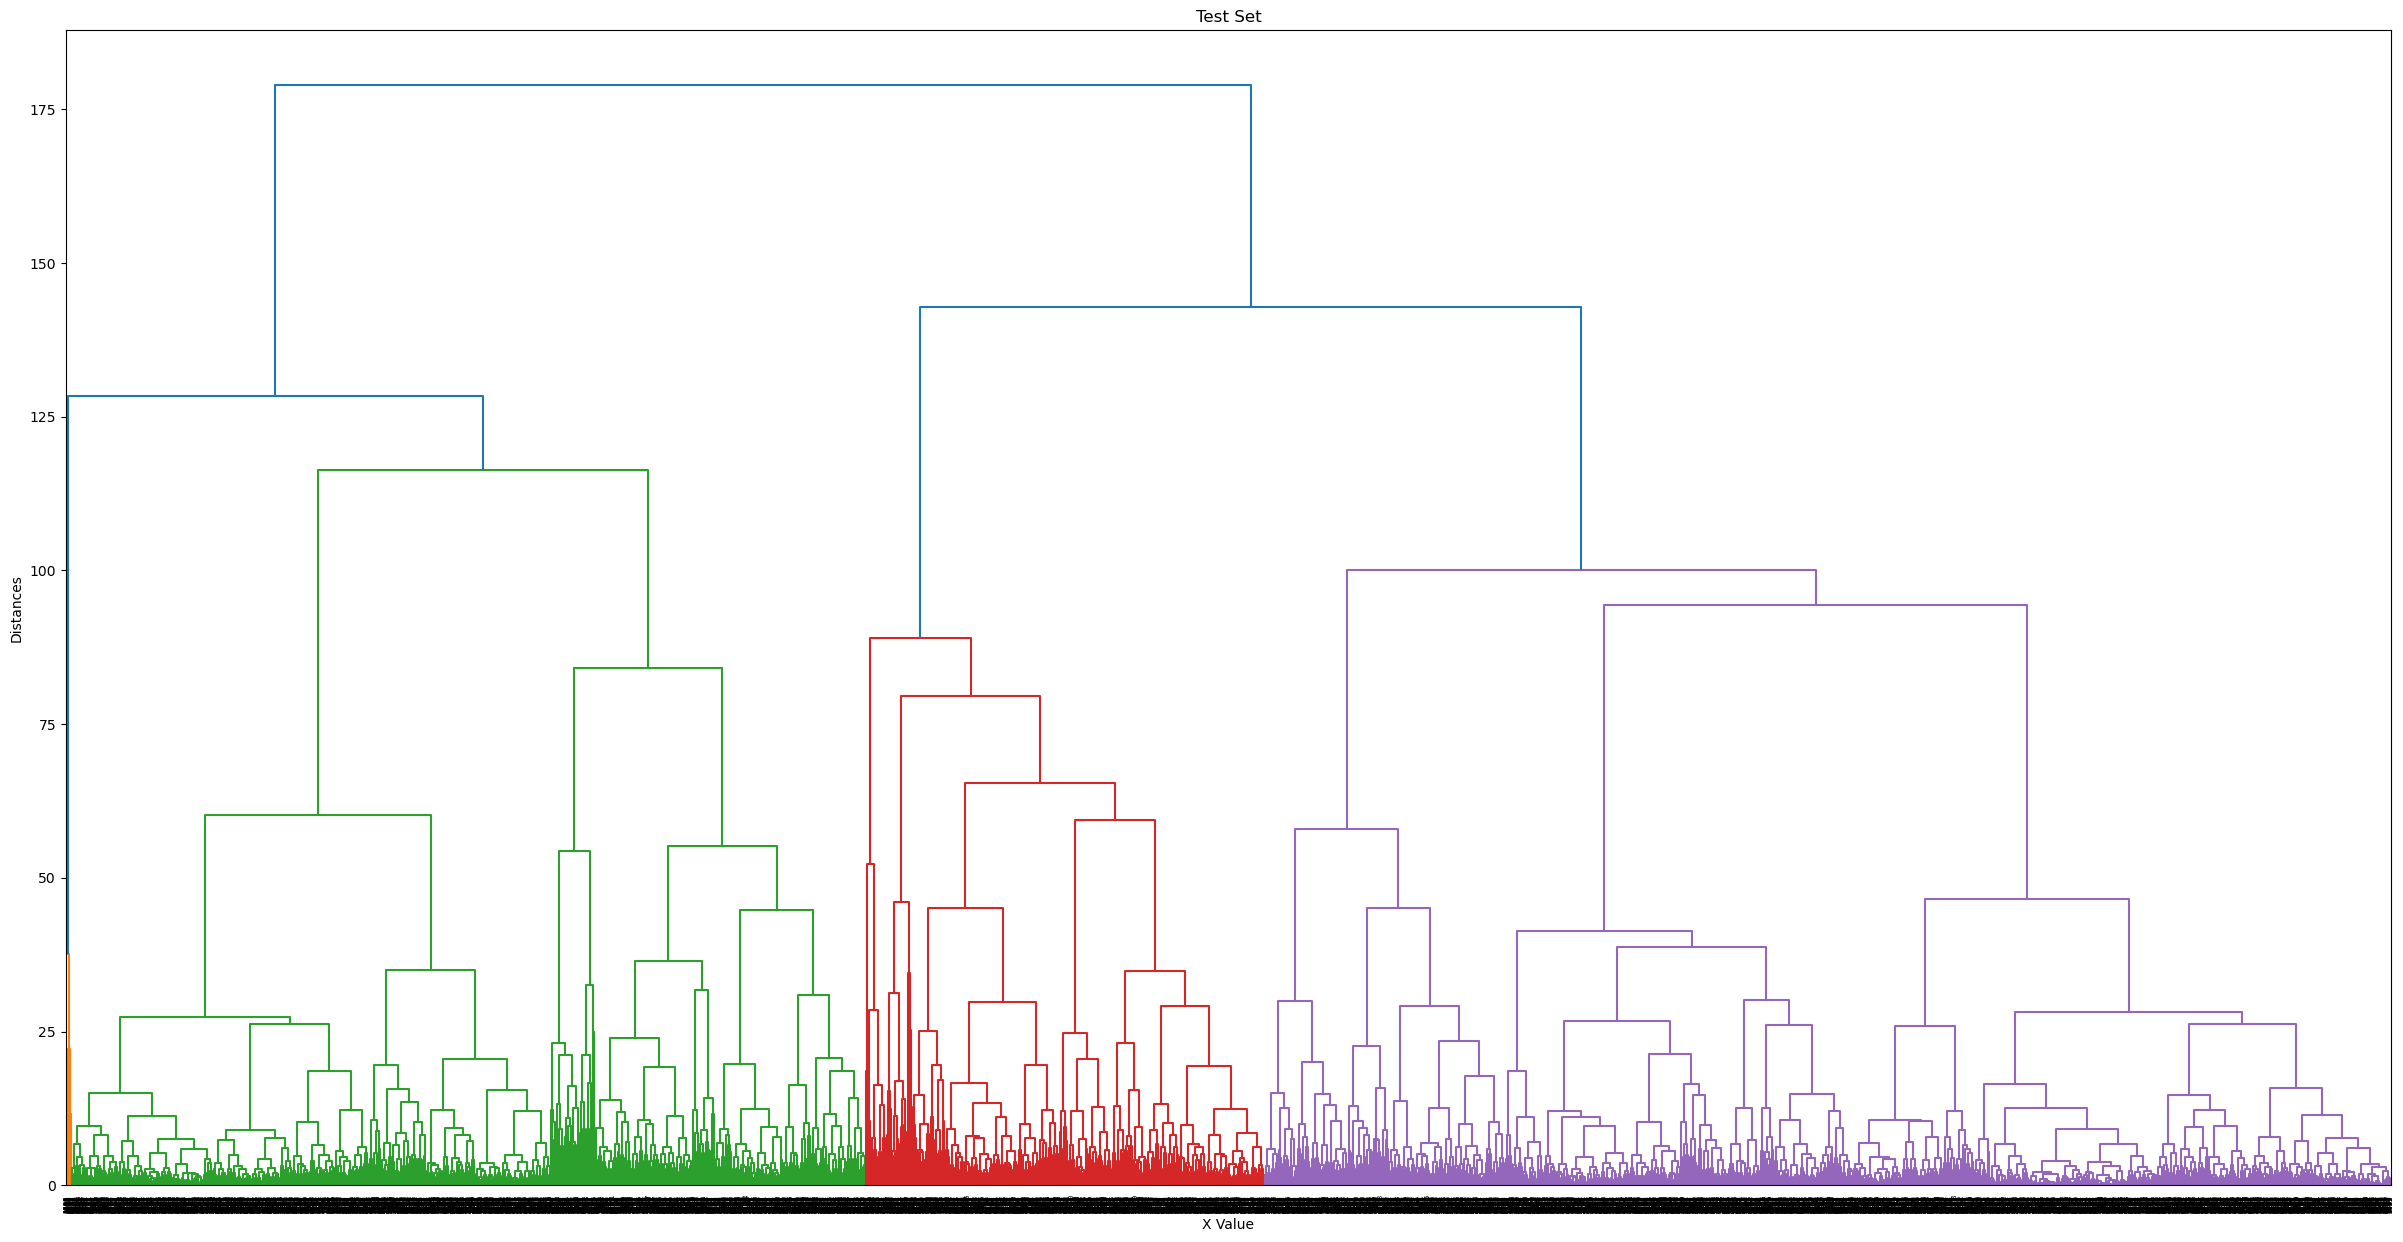

In [57]:
plt.figure(figsize=(30,15))
dendrogram = sch.dendrogram(sch.linkage(X_test, method = 'ward'))
plt.title('Test Set')
plt.xlabel('X Value')
plt.ylabel('Distances')
plt.show()

## Project Owner : Ahmet K.